In [30]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

H, W, NLABELS = 112, 112, 2

In [44]:
img = np.load('input_var.npy')
img = img[0,:,:][:,:,np.newaxis]

pred = np.load('output_fin.npy')
pred = pred[0, :, :]
pred = np.tile(pred[np.newaxis, :, :], (2,1,1))
pred[1, :, :] = 1 - pred[0, :, :]

pos = np.stack(np.mgrid[0:H, 0:W], axis=2)
rv = multivariate_normal([H // 2, W // 2 - 15], (H // 9) * (W // 9))
pred = rv.pdf(pos)
pred = (pred - pred.min()) / (pred.max() - pred.min())
pred = 0.5 + 0.2 * (pred - 0.5)
pred = np.tile(pred[np.newaxis, :, :], (2, 1, 1))
pred[1, :, :] = 1 - pred[0, :, :]

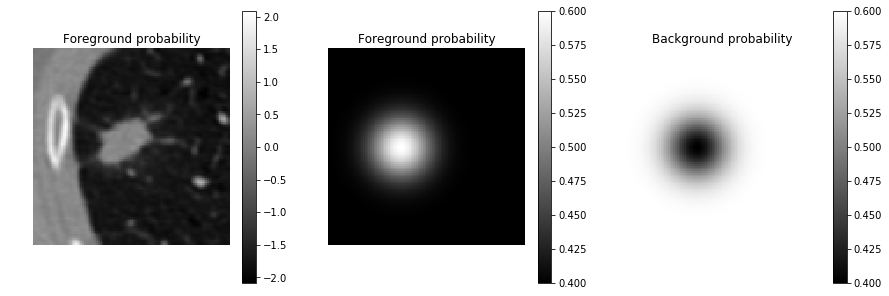

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1);
plt.imshow(img[:, :, 0]);
plt.title('Foreground probability');
plt.axis('off');
plt.colorbar();

plt.subplot(1, 3, 2);
plt.imshow(pred[0, :, :]);
plt.title('Foreground probability');
plt.axis('off');
plt.colorbar();

plt.subplot(1, 3, 3);
plt.imshow(pred[1, :, :]);
plt.title('Background probability');
plt.axis('off');
plt.colorbar();
plt.show()

In [46]:
d = dcrf.DenseCRF2D(W, H, NLABELS)

U = unary_from_softmax(pred)  # note: num classes is first dim
d.setUnaryEnergy(U)

pairwise_energy = create_pairwise_bilateral(sdims=(10,10), schan=(0.01,), img=img, chdim=2)
d.addPairwiseEnergy(pairwise_energy, compat=10)

In [47]:
Q, tmp1, tmp2 = d.startInference()
for _ in range(5):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln1 = np.argmax(Q, axis=0).reshape((H,W))

for _ in range(20):
    d.stepInference(Q, tmp1, tmp2)
kl2 = d.klDivergence(Q) / (H*W)
map_soln2 = np.argmax(Q, axis=0).reshape((H,W))

for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl3 = d.klDivergence(Q) / (H*W)
map_soln3 = np.argmax(Q, axis=0).reshape((H,W))

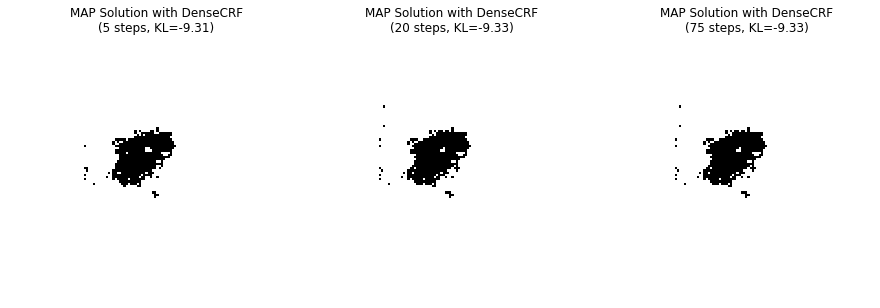

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(map_soln1);
plt.title('MAP Solution with DenseCRF\n(5 steps, KL={:.2f})'.format(kl1)); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(map_soln2);
plt.title('MAP Solution with DenseCRF\n(20 steps, KL={:.2f})'.format(kl2)); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(map_soln3);
plt.title('MAP Solution with DenseCRF\n(75 steps, KL={:.2f})'.format(kl3)); plt.axis('off');
plt.show()